In [1]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [2]:
MODE = 'DW_SH1N_SH3N_SH4N_SL1_SL2_SL3_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'mggpo_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.47599,-0.140523,-0.379702,-0.318519,-0.85627,-0.707061,-0.47599,-0.47599,-0.47599,-0.140523,-0.140523,-0.140523,-0.379702,-0.379702,-0.379702
1,0.47599,0.140523,0.379702,0.318519,0.85627,0.707061,0.47599,0.47599,0.47599,0.140523,0.140523,0.140523,0.379702,0.379702,0.379702


In [3]:
#TEST_MODE = True
TEST_MODE = False

In [4]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.476 -> +3.491
SH3N   : -1.171 + -0.141 -> -1.312
SH4N   : -3.164 + -0.380 -> -3.544
SL1    : -2.654 + -0.319 -> -2.973
SL2    : +7.136 + -0.856 -> +6.279
SL3    : -5.892 + -0.707 -> -6.599
SH1-DW08: +3.967 + -0.476 -> +3.491
SH1-DW18: +3.967 + -0.476 -> +3.491
SH1-DW28: +3.967 + -0.476 -> +3.491
SH3-DW08: -1.171 + -0.141 -> -1.312
SH3-DW18: -1.171 + -0.141 -> -1.312
SH3-DW28: -1.171 + -0.141 -> -1.312
SH4-DW08: -3.164 + -0.380 -> -3.544
SH4-DW18: -3.164 + -0.380 -> -3.544
SH4-DW28: -3.164 + -0.380 -> -3.544


{'SH1N': 3.4905925296,
 'SH3N': -1.31154428384,
 'SH4N': -3.54388175904,
 'SL1': -2.9728397552000003,
 'SL2': 6.279314175200001,
 'SL3': -6.599232776640001,
 'SH1-DW08': 3.4905925296,
 'SH1-DW18': 3.4905925296,
 'SH1-DW28': 3.4905925296,
 'SH3-DW08': -1.31154428384,
 'SH3-DW18': -1.31154428384,
 'SH3-DW28': -1.31154428384,
 'SH4-DW08': -3.54388175904,
 'SH4-DW18': -3.54388175904,
 'SH4-DW28': -3.54388175904}

### Test eval function

In [5]:
# Test
if False and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [6]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs, ivals)
ev = FunctionEvaluator(script=eval_f)

POP_SIZE = 8
generator_name = 'aps_mggpo'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs, population_size = POP_SIZE)
gen.reference_point = reference_point

[DEBUG][21:30:53.957 __init__.p   47] Creating converter from 7 to 5
[DEBUG][21:30:53.958 __init__.p   47] Creating converter from 5 to 7
[DEBUG][21:30:53.959 __init__.p   47] Creating converter from 7 to 5
[DEBUG][21:30:53.960 __init__.p   47] Creating converter from 5 to 7
[INFO ][21:30:54.018 generator.   16] Initializing generator aps_mggpo
[INFO ][21:30:54.019 generator.   64] Initialized generator aps_mggpo
[INFO ][21:30:54.019    moga.py   24] Initializing generator aps_moga
[INFO ][21:30:54.020 generator.   64] Initialized generator aps_moga
[INFO ][21:30:54.021   cnsga.py  283] Created toolbox with 15 variables, 0 constraints, and 2 objectives.
[INFO ][21:30:54.022   cnsga.py  286]     Using selection algorithm: nsga2


In [7]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][21:30:54.031 optimizer.   83] Initializing optimizer with tag='de9872d39e' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][21:30:54.032 optimizer.  138] Generator set to: supports_batch_generation=False supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.379701617

### Sample at initial values

In [8]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][21:30:54.057 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:30:54.060 evaluators  193] Data kwargs: row={'SH1N': -0.08, 'SH3N': -0.04, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': -0.15, 'SL3': -0.15, 'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.02, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.02, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][21:30:54.084 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8865824200000003, 'SH3N': -1.211021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 6.98558429, 'SL3': -6.042172122000001, 'SH1-DW08': 3.9865824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.1510216819999999, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.144180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.010; RMS(dx, dy) [m] = (6.375e-07, 1.080e-06)
Orbit correction converged


[INFO ][21:30:58.189 opt_funcs.  734] Lifetime measurement START
[INFO ][21:31:06.159 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.742 (raw tau [hr] = 7.104, epsy [pm] = 13.32) (took 8.0 [s])
Inj. Eff. = 24.49 (took 19.8 [s])
Eval. func. finished.


[DEBUG][21:31:25.994 evaluators  211] Result: output={'result': {'_nux': 0.21588002340597578, '_nuy': 0.2684614809117758, '_eps_x_bxbOn': 1.009580812163208e-09, '_eps_y_bxbOn': 1.3461250219574527e-11, '_eps_x_bxbOff': 1.0157554697401146e-09, '_eps_y_bxbOff': 1.3324490734154955e-11, 'LT': 6.741538057784293, '_raw_LT': 7.103550115399946, 'EFF': 24.491359360810158}, 'exception': None, 'traceback': '', 'wall_time': 31.932320655323565, 'cpu_time': 13.294947812}
[DEBUG][21:31:25.996 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:31:26.008 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00000.json] in [0.00782]s


MOGA add_data (+1): len(self._offspring)=1/8


In [9]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.08,-0.04,0.0,0.0,-0.15,-0.15,0.02,0.0,0.0,0.02,...,True,0.21588,0.268461,1.009581e-09,1.346125e-11,1.015755e-09,1.332449e-11,6.741538,7.10355,24.491359


### Sample close to initial point

In [10]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=POP_SIZE-1, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][21:31:45.115 optimizer.  573] Evaluating 7 inputs
[DEBUG][21:31:45.118 evaluators  193] Data kwargs: row={'SH1-DW08': 0.005258505811898469, 'SH1-DW18': 0.008194165981640477, 'SH1-DW28': -0.0044244326867178795, 'SH1N': -0.09946470700595159, 'SH3-DW08': 0.02532790670671496, 'SH3-DW18': -0.0065599156752897455, 'SH3-DW28': 0.0006760971626078756, 'SH3N': -0.0449291811354135, 'SH4-DW08': 0.002665011230644483, 'SH4-DW18': 0.009912362981078317, 'SH4-DW28': -0.010431454415446642, 'SH4N': -0.0027625833136828842, 'SL1': -0.00044333432573938, 'SL2': -0.16711553518820305, 'SL3': -0.12788348255010634}
[INFO ][21:31:45.123 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8671177129940486, 'SH3N': -1.2159508631354135, 'SH4N': -3.166942725313683, 'SL1': -2.6547645443257397, 'SL2': 6.968468754811798, 'SL3': -6.020055604550107, 'SH1-DW08': 3.971840925811899, 'SH1-DW18': 3.974776585981641, 'SH1-DW28': 3.9621579873132826, 'SH3-DW08': -1.145693775293285, 'SH3-DW18': -1.1775815976752897, 'SH3-DW28':

SH1N   : +3.967 + -0.099 -> +3.867
SH3N   : -1.171 + -0.045 -> -1.216
SH4N   : -3.164 + -0.003 -> -3.167
SL1    : -2.654 + -0.000 -> -2.655
SL2    : +7.136 + -0.167 -> +6.968
SL3    : -5.892 + -0.128 -> -6.020
SH1-DW08: +3.967 + +0.005 -> +3.972
SH1-DW18: +3.967 + +0.008 -> +3.975
SH1-DW28: +3.967 + -0.004 -> +3.962
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.007 -> -1.178
SH3-DW28: -1.171 + +0.001 -> -1.170
SH4-DW08: -3.164 + +0.003 -> -3.162
SH4-DW18: -3.164 + +0.010 -> -3.154
SH4-DW28: -3.164 + -0.010 -> -3.175
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.044; RMS(dx, dy) [m] = (1.310e-06, 1.073e-06)
Orbit correction converged


[INFO ][21:31:49.315 opt_funcs.  734] Lifetime measurement START
[INFO ][21:31:54.793 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.715 (raw tau [hr] = 7.040, epsy [pm] = 13.16) (took 5.5 [s])
Inj. Eff. = 19.53 (took 19.1 [s])
Eval. func. finished.


[DEBUG][21:32:13.882 evaluators  211] Result: output={'result': {'_nux': 0.21533070580509675, '_nuy': 0.2688581996531565, '_eps_x_bxbOn': 1.0131215170146573e-09, '_eps_y_bxbOn': 1.3254128202443333e-11, '_eps_x_bxbOff': 1.0148009464521294e-09, '_eps_y_bxbOff': 1.3159786563040686e-11, 'LT': 6.714954193222485, '_raw_LT': 7.040210193490811, 'EFF': 19.52798110997914}, 'exception': None, 'traceback': '', 'wall_time': 28.762994947843254, 'cpu_time': 10.960882199999997}
[DEBUG][21:32:13.883 evaluators  193] Data kwargs: row={'SH1-DW08': 0.028457595128364946, 'SH1-DW18': -0.015234116060801238, 'SH1-DW28': 0.01954742381484199, 'SH1N': -0.05803429602178058, 'SH3-DW08': 0.013865439178938064, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.03514161317880596, 'SH4-DW08': 0.03687971251013819, 'SH4-DW18': -0.010783225823095727, 'SH4-DW28': 0.0186282769257598, 'SH4N': 0.011871879804719362, 'SL1': 0.012815237394405377, 'SL2': -0.13049932209888915, 'SL3': -0.1828013243038

SH1N   : +3.967 + -0.058 -> +3.909
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + +0.012 -> -3.152
SL1    : -2.654 + +0.013 -> -2.642
SL2    : +7.136 + -0.130 -> +7.005
SL3    : -5.892 + -0.183 -> -6.075
SH1-DW08: +3.967 + +0.028 -> +3.995
SH1-DW18: +3.967 + -0.015 -> +3.951
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (7.215e-07, 1.062e-06)
Orbit correction converged


[INFO ][21:32:17.970 opt_funcs.  734] Lifetime measurement START
[INFO ][21:32:24.874 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.838 (raw tau [hr] = 7.233, epsy [pm] = 13.37) (took 6.9 [s])
Inj. Eff. = 44.07 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:32:43.433 evaluators  211] Result: output={'result': {'_nux': 0.21545278086182013, '_nuy': 0.2687971621247948, '_eps_x_bxbOn': 1.0143753799708947e-09, '_eps_y_bxbOn': 1.3327810228950824e-11, '_eps_x_bxbOff': 1.015409191172061e-09, '_eps_y_bxbOff': 1.3374214952824899e-11, 'LT': 6.8378499139094036, '_raw_LT': 7.233200263996898, 'EFF': 44.0665807550007}, 'exception': None, 'traceback': '', 'wall_time': 29.549271057359874, 'cpu_time': 12.709089376000001}
[DEBUG][21:32:43.435 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03835623246807433, 'SH1-DW18': 0.02337712207802192, 'SH1-DW28': -0.01951034884031021, 'SH1N': -0.08691478990603707, 'SH3-DW08': 0.017814161282481297, 'SH3-DW18': 0.006412503455532547, 'SH3-DW28': 0.005723666404894086, 'SH3N': -0.03844162280698543, 'SH4-DW08': 0.02583971906845725, 'SH4-DW18': -0.0004233768174566159, 'SH4-DW28': 0.0036053431478873903, 'SH4N': 0.006573921520382428, 'SL1': -0.009609479139732122, 'SL2': -0.179889209478871, 'SL3': -0.155408375073743

SH1N   : +3.967 + -0.087 -> +3.880
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + +0.007 -> -3.158
SL1    : -2.654 + -0.010 -> -2.664
SL2    : +7.136 + -0.180 -> +6.956
SL3    : -5.892 + -0.155 -> -6.048
SH1-DW08: +3.967 + +0.038 -> +4.005
SH1-DW18: +3.967 + +0.023 -> +3.990
SH1-DW28: +3.967 + -0.020 -> +3.947
SH3-DW08: -1.171 + +0.018 -> -1.153
SH3-DW18: -1.171 + +0.006 -> -1.165
SH3-DW28: -1.171 + +0.006 -> -1.165
SH4-DW08: -3.164 + +0.026 -> -3.138
SH4-DW18: -3.164 + -0.000 -> -3.165
SH4-DW28: -3.164 + +0.004 -> -3.161
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.037; RMS(dx, dy) [m] = (8.987e-07, 1.112e-06)
Orbit correction converged


[INFO ][21:32:47.531 opt_funcs.  734] Lifetime measurement START
[INFO ][21:32:54.072 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.721 (raw tau [hr] = 7.046, epsy [pm] = 13.11) (took 6.5 [s])
Inj. Eff. = 16.29 (took 18.9 [s])
Eval. func. finished.


[DEBUG][21:33:12.976 evaluators  211] Result: output={'result': {'_nux': 0.21511708957161296, '_nuy': 0.2687971621247948, '_eps_x_bxbOn': 1.0143290137916333e-09, '_eps_y_bxbOn': 1.3187607237364148e-11, '_eps_x_bxbOff': 1.0143523966143163e-09, '_eps_y_bxbOff': 1.3109081859291376e-11, 'LT': 6.721174082414502, '_raw_LT': 7.04551652776769, 'EFF': 16.28592578951306}, 'exception': None, 'traceback': '', 'wall_time': 29.540023035369813, 'cpu_time': 12.807265821999998}
[DEBUG][21:33:12.977 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019897127587551446, 'SH1-DW18': -5.1258648180028954e-05, 'SH1-DW28': 0.004093907211534523, 'SH1N': -0.06889331112663843, 'SH3-DW08': 0.02225659967361078, 'SH3-DW18': -0.0015355473816776192, 'SH3-DW28': -0.002222078608244426, 'SH3N': -0.041601614262225334, 'SH4-DW08': 0.014911551733651045, 'SH4-DW18': 0.0012963986089513484, 'SH4-DW28': -0.00526677632062714, 'SH4N': -0.01645905175703876, 'SL1': 0.005017787410252515, 'SL2': -0.12316489681590673, 'SL3': -0.1352867

SH1N   : +3.967 + -0.069 -> +3.898
SH3N   : -1.171 + -0.042 -> -1.213
SH4N   : -3.164 + -0.016 -> -3.181
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.123 -> +7.012
SL3    : -5.892 + -0.135 -> -6.027
SH1-DW08: +3.967 + +0.020 -> +3.986
SH1-DW18: +3.967 + -0.000 -> +3.967
SH1-DW28: +3.967 + +0.004 -> +3.971
SH3-DW08: -1.171 + +0.022 -> -1.149
SH3-DW18: -1.171 + -0.002 -> -1.173
SH3-DW28: -1.171 + -0.002 -> -1.173
SH4-DW08: -3.164 + +0.015 -> -3.149
SH4-DW18: -3.164 + +0.001 -> -3.163
SH4-DW28: -3.164 + -0.005 -> -3.169
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.192; RMS(dx, dy) [m] = (3.164e-06, 1.950e-06)
Max FCOR I [A] = 0.192; RMS(dx, dy) [m] = (3.164e-06, 1.950e-06)
Max FCOR I [A] = 0.156; RMS(dx, dy) [m] = (2.295e-06, 1.288e-06)
Max FCOR I [A] = 0.156; RMS(dx, dy) [m] = (2.295e-06, 1.288e-06)
Max FCOR I [A] = 0.125; RMS(dx, dy) [m] = (1.771e-06, 1.624e-06)
Max FCOR I [A] = 0.125; RMS(dx, dy) [m] = (1.771e-06, 1.624e-06)
Max FCOR I [A] = 0.136; RMS(dx, dy) [m] = (1.756e-0

[INFO ][21:33:29.104 opt_funcs.  734] Lifetime measurement START
[INFO ][21:33:39.160 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.948 (raw tau [hr] = 7.389, epsy [pm] = 13.47) (took 10.1 [s])
Inj. Eff. = 21.48 (took 17.6 [s])
Eval. func. finished.


[DEBUG][21:33:56.791 evaluators  211] Result: output={'result': {'_nux': 0.21697864853054574, '_nuy': 0.26812578962156863, '_eps_x_bxbOn': 1.0045735058244794e-09, '_eps_y_bxbOn': 1.348549467947163e-11, '_eps_x_bxbOff': 1.0040801311630324e-09, '_eps_y_bxbOff': 1.3468665632867209e-11, 'LT': 6.947714337134522, '_raw_LT': 7.389292732238215, 'EFF': 21.483817478514954}, 'exception': None, 'traceback': '', 'wall_time': 43.812278249301016, 'cpu_time': 16.510093756000003}
[DEBUG][21:33:56.792 evaluators  193] Data kwargs: row={'SH1-DW08': 0.01043739009746679, 'SH1-DW18': 0.016947234801634212, 'SH1-DW28': 0.014087449513261307, 'SH1N': -0.07772913060150663, 'SH3-DW08': 0.02140421661001142, 'SH3-DW18': -0.005187396721021536, 'SH3-DW28': 0.004225502685363675, 'SH3N': -0.03742405127566588, 'SH4-DW08': 0.02327474443640369, 'SH4-DW18': -0.017435389990703213, 'SH4-DW28': 0.006583249451334382, 'SH4N': -0.010899188367373821, 'SL1': -0.015084780184247115, 'SL2': -0.14857596817898197, 'SL3': -0.14977536411

SH1N   : +3.967 + -0.078 -> +3.889
SH3N   : -1.171 + -0.037 -> -1.208
SH4N   : -3.164 + -0.011 -> -3.175
SL1    : -2.654 + -0.015 -> -2.669
SL2    : +7.136 + -0.149 -> +6.987
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.010 -> +3.977
SH1-DW18: +3.967 + +0.017 -> +3.984
SH1-DW28: +3.967 + +0.014 -> +3.981
SH3-DW08: -1.171 + +0.021 -> -1.150
SH3-DW18: -1.171 + -0.005 -> -1.176
SH3-DW28: -1.171 + +0.004 -> -1.167
SH4-DW08: -3.164 + +0.023 -> -3.141
SH4-DW18: -3.164 + -0.017 -> -3.182
SH4-DW28: -3.164 + +0.007 -> -3.158
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.052; RMS(dx, dy) [m] = (1.128e-06, 1.204e-06)
Orbit correction converged


[INFO ][21:34:00.871 opt_funcs.  734] Lifetime measurement START
[INFO ][21:34:06.891 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.939 (raw tau [hr] = 7.376, epsy [pm] = 13.43) (took 6.0 [s])
Inj. Eff. = 14.29 (took 17.4 [s])
Eval. func. finished.


[DEBUG][21:34:24.303 evaluators  211] Result: output={'result': {'_nux': 0.2163072558729433, '_nuy': 0.2683089022066537, '_eps_x_bxbOn': 1.0044481915496666e-09, '_eps_y_bxbOn': 1.3519267183127584e-11, '_eps_x_bxbOff': 1.0031329410501472e-09, '_eps_y_bxbOff': 1.3432468886370927e-11, 'LT': 6.939272202673135, '_raw_LT': 7.376186482444376, 'EFF': 14.285994927090329}, 'exception': None, 'traceback': '', 'wall_time': 27.509946537204087, 'cpu_time': 12.232859992000002}
[DEBUG][21:34:24.305 evaluators  193] Data kwargs: row={'SH1-DW08': 0.03512599410590484, 'SH1-DW18': -0.007223385481137115, 'SH1-DW28': -0.009888036103008742, 'SH1N': -0.08348190732079384, 'SH3-DW08': 0.0187180058855724, 'SH3-DW18': 0.0027265608973721777, 'SH3-DW28': -0.0007007459665230881, 'SH3N': -0.04261503393595758, 'SH4-DW08': 0.017178449685004607, 'SH4-DW18': 0.018972583612353766, 'SH4-DW28': -0.0035123356018836698, 'SH4N': 0.0017527675144206958, 'SL1': 0.003524059016674328, 'SL2': -0.1543997213607088, 'SL3': -0.160497264

SH1N   : +3.967 + -0.083 -> +3.883
SH3N   : -1.171 + -0.043 -> -1.214
SH4N   : -3.164 + +0.002 -> -3.162
SL1    : -2.654 + +0.004 -> -2.651
SL2    : +7.136 + -0.154 -> +6.981
SL3    : -5.892 + -0.160 -> -6.053
SH1-DW08: +3.967 + +0.035 -> +4.002
SH1-DW18: +3.967 + -0.007 -> +3.959
SH1-DW28: +3.967 + -0.010 -> +3.957
SH3-DW08: -1.171 + +0.019 -> -1.152
SH3-DW18: -1.171 + +0.003 -> -1.168
SH3-DW28: -1.171 + -0.001 -> -1.172
SH4-DW08: -3.164 + +0.017 -> -3.147
SH4-DW18: -3.164 + +0.019 -> -3.145
SH4-DW28: -3.164 + -0.004 -> -3.168
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (1.026e-06, 1.060e-06)
Orbit correction converged


[INFO ][21:34:28.393 opt_funcs.  734] Lifetime measurement START
[INFO ][21:34:33.310 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.970 (raw tau [hr] = 7.381, epsy [pm] = 13.32) (took 4.9 [s])
Inj. Eff. = 13.94 (took 17.5 [s])
Eval. func. finished.


[DEBUG][21:34:50.793 evaluators  211] Result: output={'result': {'_nux': 0.21655139590920197, '_nuy': 0.2682173408755171, '_eps_x_bxbOn': 1.0032127474381484e-09, '_eps_y_bxbOn': 1.335373381779331e-11, '_eps_x_bxbOff': 1.00135207075023e-09, '_eps_y_bxbOff': 1.3320671141985473e-11, 'LT': 6.969546441636185, '_raw_LT': 7.3811199037016815, 'EFF': 13.944779349781191}, 'exception': None, 'traceback': '', 'wall_time': 26.486751013435423, 'cpu_time': 11.332425745999998}
[DEBUG][21:34:50.794 evaluators  193] Data kwargs: row={'SH1-DW08': 0.02569366672699642, 'SH1-DW18': 0.00196245958006621, 'SH1-DW28': 0.009832054910429888, 'SH1N': -0.06779111939428267, 'SH3-DW08': 0.014769588428941311, 'SH3-DW18': 0.005150196626432894, 'SH3-DW28': 0.0022467198738699568, 'SH3N': -0.045887598940175946, 'SH4-DW08': 0.009679755442766403, 'SH4-DW18': 0.007937136314204028, 'SH4-DW28': -0.016978588043551863, 'SH4N': 0.0177298323636988, 'SL1': -0.006916449275437811, 'SL2': -0.11313603353347712, 'SL3': -0.16859952351715

SH1N   : +3.967 + -0.068 -> +3.899
SH3N   : -1.171 + -0.046 -> -1.217
SH4N   : -3.164 + +0.018 -> -3.146
SL1    : -2.654 + -0.007 -> -2.661
SL2    : +7.136 + -0.113 -> +7.022
SL3    : -5.892 + -0.169 -> -6.061
SH1-DW08: +3.967 + +0.026 -> +3.992
SH1-DW18: +3.967 + +0.002 -> +3.969
SH1-DW28: +3.967 + +0.010 -> +3.976
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + +0.005 -> -1.166
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.010 -> -3.155
SH4-DW18: -3.164 + +0.008 -> -3.156
SH4-DW28: -3.164 + -0.017 -> -3.181
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.091; RMS(dx, dy) [m] = (1.225e-06, 1.439e-06)
Orbit correction converged


[INFO ][21:34:54.872 opt_funcs.  734] Lifetime measurement START
[INFO ][21:35:00.738 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.820 (raw tau [hr] = 7.274, epsy [pm] = 13.49) (took 5.9 [s])
Inj. Eff. = 34.64 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:35:19.326 evaluators  211] Result: output={'result': {'_nux': 0.21581898587761408, '_nuy': 0.26833941593224053, '_eps_x_bxbOn': 1.0072842353707552e-09, '_eps_y_bxbOn': 1.3510489399823858e-11, '_eps_x_bxbOff': 1.0102210837044646e-09, '_eps_y_bxbOff': 1.3485443325610347e-11, 'LT': 6.82037051394435, '_raw_LT': 7.27381174185285, 'EFF': 34.64199092126434}, 'exception': None, 'traceback': '', 'wall_time': 28.53127255383879, 'cpu_time': 12.244631061999996}
[DEBUG][21:35:19.330 optimizer.  291] Adding (7) new data to internal dataframes
[DEBUG][21:35:19.365 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00001.json] in [0.02278]s


MOGA add_data (+8): len(self._offspring)=9/8
MOGA add_data: creating next generation


In [11]:
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.080000,-0.040000,0.000000,0.000000,-0.150000,-0.150000,0.020000,0.000000,0.000000,0.020000,...,True,0.215880,0.268461,1.009581e-09,1.346125e-11,1.015755e-09,1.332449e-11,6.741538,7.103550,24.491359
2,-0.099465,-0.044929,-0.002763,-0.000443,-0.167116,-0.127883,0.005259,0.008194,-0.004424,0.025328,...,True,0.215331,0.268858,1.013122e-09,1.325413e-11,1.014801e-09,1.315979e-11,6.714954,7.040210,19.527981
3,-0.058034,-0.035142,0.011872,0.012815,-0.130499,-0.182801,0.028458,-0.015234,0.019547,0.013865,...,True,0.215453,0.268797,1.014375e-09,1.332781e-11,1.015409e-09,1.337421e-11,6.837850,7.233200,44.066581
4,-0.086915,-0.038442,0.006574,-0.009609,-0.179889,-0.155408,0.038356,0.023377,-0.019510,0.017814,...,True,0.215117,0.268797,1.014329e-09,1.318761e-11,1.014352e-09,1.310908e-11,6.721174,7.045517,16.285926
5,-0.068893,-0.041602,-0.016459,0.005018,-0.123165,-0.135287,0.019897,-0.000051,0.004094,0.022257,...,True,0.216979,0.268126,1.004574e-09,1.348549e-11,1.004080e-09,1.346867e-11,6.947714,7.389293,21.483817
6,-0.077729,-0.037424,-0.010899,-0.015085,-0.148576,-0.149775,0.010437,0.016947,0.014087,0.021404,...,True,0.216307,0.268309,1.004448e-09,1.351927e-11,1.003133e-09,1.343247e-11,6.939272,7.376186,14.285995
7,-0.083482,-0.042615,0.001753,0.003524,-0.154400,-0.160497,0.035126,-0.007223,-0.009888,0.018718,...,True,0.216551,0.268217,1.003213e-09,1.335373e-11,1.001352e-09,1.332067e-11,6.969546,7.381120,13.944779
8,-0.067791,-0.045888,0.017730,-0.006916,-0.113136,-0.168600,0.025694,0.001962,0.009832,0.014770,...,True,0.215819,0.268339,1.007284e-09,1.351049e-11,1.010221e-09,1.348544e-11,6.820371,7.273812,34.641991


### Run optimizer

In [12]:
opt.step()

[DEBUG][21:36:15.639 optimizer.  447] Generating 1 candidates
[DEBUG][21:36:15.641 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.37970161704]}, constraints={}, objectives={'LT': 'MAXIMIZE', 'EFF': 'MAXIMIZE'}, constants={}, observables=[]) with len(data)=8
[DEBUG][21:36:16.179   mggpo.py   4

SH1N   : +3.967 + -0.049 -> +3.917
SH3N   : -1.171 + -0.035 -> -1.206
SH4N   : -3.164 + -0.017 -> -3.181
SL1    : -2.654 + +0.013 -> -2.642
SL2    : +7.136 + -0.130 -> +7.005
SL3    : -5.892 + -0.183 -> -6.075
SH1-DW08: +3.967 + +0.028 -> +3.995
SH1-DW18: +3.967 + -0.000 -> +3.966
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.015 -> -3.149
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.051; RMS(dx, dy) [m] = (1.281e-06, 1.288e-06)
Orbit correction converged


[INFO ][21:36:20.313 opt_funcs.  734] Lifetime measurement START
[INFO ][21:36:25.873 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.826 (raw tau [hr] = 7.236, epsy [pm] = 13.27) (took 5.6 [s])
Inj. Eff. = 29.38 (took 20.0 [s])
Eval. func. finished.


[DEBUG][21:36:45.924 evaluators  211] Result: output={'result': {'_nux': 0.21517811702278658, '_nuy': 0.2686751072224477, '_eps_x_bxbOn': 1.0141267170855476e-09, '_eps_y_bxbOn': 1.3409101516545188e-11, '_eps_x_bxbOff': 1.0114020477234055e-09, '_eps_y_bxbOff': 1.3268731750131938e-11, 'LT': 6.826170505450623, '_raw_LT': 7.236221133030238, 'EFF': 29.38443105750739}, 'exception': None, 'traceback': '', 'wall_time': 29.685021083801985, 'cpu_time': 17.673852324999984}
[DEBUG][21:36:45.927 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:36:45.956 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00002.json] in [0.01924]s


MOGA add_data (+9): len(self._offspring)=9/8
MOGA add_data: creating next generation


In [16]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][21:49:33.961 optimizer.  447] Generating 1 candidates
[DEBUG][21:49:33.965 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.37970161704]}, constraints={}, objectives={'LT': 'MAXIMIZE', 'EFF': 'MAXIMIZE'}, constants={}, observables=[]) with len(data)=29



** Step #1 at 2023-12-16 21:49:33**



[DEBUG][21:49:34.272   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=29)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:49:34.353 bayesian_g  248] Best candidate from optimize tensor([[-0.0875, -0.0708,  0.0199,  0.0746,  0.0139,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0186,  0.0887,  0.0128, -0.0725, -0.1359]],
       dtype=torch.float64)
[DEBUG][21:49:34.355 optimizer.  488] Generated 1 inputs
[INFO ][21:49:34.359 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:49:34.361 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08750336653580201, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.0199333369873436, 'SH1N': 0.07462552312169968, 'SH3-DW08': 0.013865055185627381, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03732511

SH1N   : +3.967 + +0.075 -> +4.041
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.075
SL1    : -2.654 + +0.013 -> -2.642
SL2    : +7.136 + -0.072 -> +7.063
SL3    : -5.892 + -0.136 -> -6.028
SH1-DW08: +3.967 + -0.088 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.087; RMS(dx, dy) [m] = (6.993e-06, 1.006e-06)
Orbit correction converged


[INFO ][21:49:39.484 opt_funcs.  734] Lifetime measurement START
[INFO ][21:49:45.422 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.190 (raw tau [hr] = 8.149, epsy [pm] = 14.58) (took 5.9 [s])
Inj. Eff. = 89.68 (took 19.3 [s])
Eval. func. finished.


[DEBUG][21:50:04.740 evaluators  211] Result: output={'result': {'_nux': 0.2164293208524786, '_nuy': 0.26739336951279263, '_eps_x_bxbOn': 1.007735438879541e-09, '_eps_y_bxbOn': 1.4662798808965375e-11, '_eps_x_bxbOff': 1.0074691472908627e-09, '_eps_y_bxbOff': 1.4581388666289114e-11, 'LT': 7.189573802218437, '_raw_LT': 8.149409152678631, 'EFF': 89.67765742968953}, 'exception': None, 'traceback': '', 'wall_time': 30.378468988463283, 'cpu_time': 18.073560678000035}
[DEBUG][21:50:04.745 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:50:04.795 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00023.json] in [0.03888]s
[DEBUG][21:50:04.796 optimizer.  447] Generating 1 candidates
[DEBUG][21:50:04.797 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704

MOGA add_data (+30): len(self._offspring)=30/8
MOGA add_data: creating next generation

** Step #2 at 2023-12-16 21:50:04**



[DEBUG][21:50:05.106   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=30)
[DEBUG][21:50:05.196 bayesian_g  248] Best candidate from optimize tensor([[-0.0875, -0.0708,  0.0814, -0.0580,  0.0139,  0.0014, -0.0042, -0.0365,
          0.0373, -0.0108,  0.0186,  0.0887,  0.0048, -0.0695, -0.1359]],
       dtype=torch.float64)
[DEBUG][21:50:05.199 optimizer.  488] Generated 1 inputs
[INFO ][21:50:05.204 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:50:05.205 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08750336653580201, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.0813644788941794, 'SH1N': -0.05803429602178058, 'SH3-DW08': 0.013865055185627381, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.03653026026184297, 'SH4-DW08': 0.037325125154740936, 'SH4-DW18': -0.01078299547915016, 'SH4-DW28': 0.018628557603935884, 'SH4N': 0.08873380816771767, 'SL1': 0.004755919724942996, 'SL2': -0.06953000830846533, 'SL3': -0.13593312264413646}


SH1N   : +3.967 + -0.058 -> +3.909
SH3N   : -1.171 + -0.037 -> -1.208
SH4N   : -3.164 + +0.089 -> -3.075
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.070 -> +7.066
SL3    : -5.892 + -0.136 -> -6.028
SH1-DW08: +3.967 + -0.088 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.081 -> +4.048
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (1.092e-06, 1.134e-06)
Orbit correction converged


[INFO ][21:50:10.320 opt_funcs.  734] Lifetime measurement START
[INFO ][21:50:15.963 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.008 (raw tau [hr] = 7.758, epsy [pm] = 13.89) (took 5.6 [s])
Inj. Eff. = 92.87 (took 19.3 [s])
Eval. func. finished.


[DEBUG][21:50:35.308 evaluators  211] Result: output={'result': {'_nux': 0.21526967835392316, '_nuy': 0.2672407807304824, '_eps_x_bxbOn': 1.0110370261487365e-09, '_eps_y_bxbOn': 1.4018075059841799e-11, '_eps_x_bxbOff': 1.0107101210664486e-09, '_eps_y_bxbOff': 1.3891732712637738e-11, 'LT': 7.007817441999342, '_raw_LT': 7.758464966333137, 'EFF': 92.86619441787629}, 'exception': None, 'traceback': '', 'wall_time': 30.10170563776046, 'cpu_time': 18.800239954999938}
[DEBUG][21:50:35.312 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:50:35.360 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00024.json] in [0.03778]s
[DEBUG][21:50:35.361 optimizer.  447] Generating 1 candidates
[DEBUG][21:50:35.363 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704

MOGA add_data (+31): len(self._offspring)=31/8
MOGA add_data: creating next generation

** Step #3 at 2023-12-16 21:50:35**



[DEBUG][21:50:35.676   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=31)
[DEBUG][21:50:35.760 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0708,  0.0199,  0.0784,  0.0060,  0.0014, -0.0042, -0.0411,
          0.0174, -0.0108,  0.0186,  0.0886,  0.0051,  0.0274, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:50:35.762 optimizer.  488] Generated 1 inputs
[INFO ][21:50:35.767 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:50:35.769 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': 0.005959504548401613, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.017412905470956093, 'SH4-DW18': -0.01078303431127639, 'SH4-DW28': 0.01861017942262072, 'SH4N': 0.08858491474598008, 'SL1': 0.005072120005437163, 'SL2': 0.027370242358712542, 'SL3': -0.13658225788963957}


SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.017 -> -3.147
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.037; RMS(dx, dy) [m] = (1.076e-06, 1.021e-06)
Orbit correction converged


[INFO ][21:50:40.884 opt_funcs.  734] Lifetime measurement START
[INFO ][21:50:48.814 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.364 (raw tau [hr] = 8.450, epsy [pm] = 14.90) (took 7.9 [s])
Inj. Eff. = 87.05 (took 20.1 [s])
Eval. func. finished.


[DEBUG][21:51:08.928 evaluators  211] Result: output={'result': {'_nux': 0.21679553594546064, '_nuy': 0.2668440519119136, '_eps_x_bxbOn': 1.0063146549680956e-09, '_eps_y_bxbOn': 1.4914180188141054e-11, '_eps_x_bxbOff': 1.0051049967550785e-09, '_eps_y_bxbOff': 1.490020788838737e-11, 'LT': 7.3642123494871115, '_raw_LT': 8.450092003867242, 'EFF': 87.04991710656542}, 'exception': None, 'traceback': '', 'wall_time': 33.15839901659638, 'cpu_time': 19.808566680000013}
[DEBUG][21:51:08.932 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:51:08.984 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00025.json] in [0.03995]s
[DEBUG][21:51:08.985 optimizer.  447] Generating 1 candidates
[DEBUG][21:51:08.986 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704

MOGA add_data (+32): len(self._offspring)=32/8
MOGA add_data: creating next generation

** Step #4 at 2023-12-16 21:51:08**



[DEBUG][21:51:09.396   mggpo.py   47] Evaluating acq on len(ga_candidates)=9 (len(self.data)=32)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:51:09.524 bayesian_g  248] Best candidate from optimize tensor([[-0.0875, -0.1287,  0.0199, -0.0583,  0.0139,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0186,  0.0886,  0.0129, -0.0725, -0.1359]],
       dtype=torch.float64)
[DEBUG][21:51:09.526 optimizer.  488] Generated 1 inputs
[INFO ][21:51:09.532 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:51:09.533 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08750336653580201, 'SH1-DW18': -0.12870628737104473, 'SH1-DW28': 0.01991622889311086, 'SH1N': -0.05825084728014602, 'SH3-DW08': 0.013865055185627381, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.037325

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.072 -> +7.063
SL3    : -5.892 + -0.136 -> -6.028
SH1-DW08: +3.967 + -0.088 -> +3.879
SH1-DW18: +3.967 + -0.129 -> +3.838
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.217; RMS(dx, dy) [m] = (3.414e-06, 1.831e-06)
Max FCOR I [A] = 0.268; RMS(dx, dy) [m] = (9.471e-06, 2.242e-06)
Max FCOR I [A] = 0.268; RMS(dx, dy) [m] = (9.471e-06, 2.242e-06)
Max FCOR I [A] = 0.231; RMS(dx, dy) [m] = (2.604e-06, 1.672e-06)
Max FCOR I [A] = 0.231; RMS(dx, dy) [m] = (2.604e-06, 1.672e-06)
Max FCOR I [A] = 0.209; RMS(dx, dy) [m] = (3.077e-06, 1.412e-06)
Max FCOR I [A] = 0.209; RMS(dx, dy) [m] = (3.077e-0

[INFO ][21:51:35.719 opt_funcs.  734] Lifetime measurement START
[INFO ][21:51:46.315 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 6.912 (raw tau [hr] = 7.652, epsy [pm] = 13.83) (took 10.6 [s])
Inj. Eff. = 93.24 (took 18.7 [s])
Eval. func. finished.


[DEBUG][21:52:04.971 evaluators  211] Result: output={'result': {'_nux': 0.21685657347382234, '_nuy': 0.2668440619891017, '_eps_x_bxbOn': 9.980049822552959e-10, '_eps_y_bxbOn': 1.4006916021813246e-11, '_eps_x_bxbOff': 1.0110543459568236e-09, '_eps_y_bxbOff': 1.3834991504700026e-11, 'LT': 6.912178662711212, '_raw_LT': 7.652261671882959, 'EFF': 93.2384440739551}, 'exception': None, 'traceback': '', 'wall_time': 55.436111968010664, 'cpu_time': 23.092067372999963}
[DEBUG][21:52:04.974 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:52:05.022 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00026.json] in [0.03881]s
[DEBUG][21:52:05.023 optimizer.  447] Generating 1 candidates
[DEBUG][21:52:05.025 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]

MOGA add_data (+33): len(self._offspring)=33/8
MOGA add_data: creating next generation

** Step #5 at 2023-12-16 21:52:05**



[DEBUG][21:52:05.337   mggpo.py   47] Evaluating acq on len(ga_candidates)=9 (len(self.data)=33)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:52:05.421 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0708,  0.0199, -0.1166,  0.0010,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0186,  0.0886,  0.0051, -0.0229, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:52:05.423 optimizer.  488] Generated 1 inputs
[INFO ][21:52:05.428 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:52:05.429 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728718331730033, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.11655602173804727, 'SH3-DW08': 0.0010395369855612183, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.037325

SH1N   : +3.967 + -0.117 -> +3.850
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.023 -> +7.113
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.001 -> -1.170
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.046; RMS(dx, dy) [m] = (1.332e-06, 1.154e-06)
Orbit correction converged


[INFO ][21:52:09.510 opt_funcs.  734] Lifetime measurement START
[INFO ][21:52:17.025 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.010 (raw tau [hr] = 7.718, epsy [pm] = 13.66) (took 7.5 [s])
Inj. Eff. = 92.22 (took 18.5 [s])
Eval. func. finished.


[DEBUG][21:52:35.537 evaluators  211] Result: output={'result': {'_nux': 0.21545277078463204, '_nuy': 0.2670576782225855, '_eps_x_bxbOn': 1.0063400547910711e-09, '_eps_y_bxbOn': 1.3833562168740851e-11, '_eps_x_bxbOff': 1.0062960675051654e-09, '_eps_y_bxbOff': 1.3658297787301851e-11, 'LT': 7.0104552002304406, '_raw_LT': 7.717552319460927, 'EFF': 92.21839351882738}, 'exception': None, 'traceback': '', 'wall_time': 30.106586410664022, 'cpu_time': 19.84579457599989}
[DEBUG][21:52:35.541 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:52:35.593 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00027.json] in [0.04152]s
[DEBUG][21:52:35.594 optimizer.  447] Generating 1 candidates
[DEBUG][21:52:35.595 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.3797016170

MOGA add_data (+34): len(self._offspring)=34/8
MOGA add_data: creating next generation

** Step #6 at 2023-12-16 21:52:35**



[DEBUG][21:52:35.923   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=34)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:52:36.022 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0692,  0.0199, -0.0582,  0.0139,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0186,  0.0886,  0.0051, -0.0229, -0.1614]],
       dtype=torch.float64)
[DEBUG][21:52:36.025 optimizer.  488] Generated 1 inputs
[INFO ][21:52:36.030 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:52:36.031 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728718331730033, 'SH1-DW18': -0.06916901483180177, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.05824740387008376, 'SH3-DW08': 0.013929691202714103, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03732

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.023 -> +7.113
SL3    : -5.892 + -0.161 -> -6.054
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.069 -> +3.897
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.013; RMS(dx, dy) [m] = (8.583e-07, 1.014e-06)
Orbit correction converged


[INFO ][21:52:40.113 opt_funcs.  734] Lifetime measurement START
[INFO ][21:52:46.491 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 6.973 (raw tau [hr] = 7.743, epsy [pm] = 13.88) (took 6.4 [s])
Inj. Eff. = 91.63 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:53:05.086 evaluators  211] Result: output={'result': {'_nux': 0.21533070580509672, '_nuy': 0.26714922947653397, '_eps_x_bxbOn': 1.0113516191815416e-09, '_eps_y_bxbOn': 1.3890702036658289e-11, '_eps_x_bxbOff': 1.0104499655146334e-09, '_eps_y_bxbOff': 1.3876859748782319e-11, 'LT': 6.973193172272729, '_raw_LT': 7.742692901320448, 'EFF': 91.63110240378896}, 'exception': None, 'traceback': '', 'wall_time': 29.05336299818009, 'cpu_time': 18.608353911999984}
[DEBUG][21:53:05.090 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:53:05.142 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00028.json] in [0.04159]s
[DEBUG][21:53:05.143 optimizer.  447] Generating 1 candidates
[DEBUG][21:53:05.144 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.3797016170

MOGA add_data (+35): len(self._offspring)=35/8
MOGA add_data: creating next generation

** Step #7 at 2023-12-16 21:53:05**



[DEBUG][21:53:05.452   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=35)
[DEBUG][21:53:05.544 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.1096,  0.0199,  0.0784, -0.0256,  0.0014, -0.0042, -0.0411,
          0.0174, -0.0108,  0.0186,  0.0886,  0.0051,  0.0274, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:53:05.547 optimizer.  488] Generated 1 inputs
[INFO ][21:53:05.552 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:53:05.553 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.10964463245696462, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': -0.025567293853351006, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.017412905470956093, 'SH4-DW18': -0.01078303431127639, 'SH4-DW28': 0.01861017942262072, 'SH4N': 0.08858491474598008, 'SL1': 0.005072120005437163, 'SL2': 0.027370242358712542, 'SL3': -0.13658225788963957

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.110 -> +3.857
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + -0.026 -> -1.197
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.017 -> -3.147
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.019; RMS(dx, dy) [m] = (1.178e-06, 1.085e-06)
Orbit correction converged


[INFO ][21:53:10.663 opt_funcs.  734] Lifetime measurement START
[INFO ][21:53:18.191 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.289 (raw tau [hr] = 8.379, epsy [pm] = 14.85) (took 7.5 [s])
Inj. Eff. = 86.00 (took 18.5 [s])
Eval. func. finished.


[DEBUG][21:53:36.672 evaluators  211] Result: output={'result': {'_nux': 0.2171007034328929, '_nuy': 0.2667525006579651, '_eps_x_bxbOn': 1.0073864240778844e-09, '_eps_y_bxbOn': 1.4916902377409246e-11, '_eps_x_bxbOff': 1.0065775826906043e-09, '_eps_y_bxbOff': 1.485234050379757e-11, 'LT': 7.289262371369618, '_raw_LT': 8.379246107514051, 'EFF': 85.99828084926375}, 'exception': None, 'traceback': '', 'wall_time': 31.117642633616924, 'cpu_time': 19.68221122700004}
[DEBUG][21:53:36.674 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:53:36.728 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00029.json] in [0.04158]s
[DEBUG][21:53:36.729 optimizer.  447] Generating 1 candidates
[DEBUG][21:53:36.729 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],

MOGA add_data (+36): len(self._offspring)=36/8
MOGA add_data: creating next generation

** Step #8 at 2023-12-16 21:53:36**



[DEBUG][21:53:37.036   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=36)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:53:37.125 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0708,  0.0199,  0.0784,  0.0060,  0.0014, -0.0042, -0.0411,
          0.0179, -0.0108,  0.0186,  0.0886,  0.0051,  0.0274, -0.0542]],
       dtype=torch.float64)
[DEBUG][21:53:37.127 optimizer.  488] Generated 1 inputs
[INFO ][21:53:37.132 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:53:37.134 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': 0.005959504548401613, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.017851

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.054 -> -5.946
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.018 -> -3.146
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.050; RMS(dx, dy) [m] = (8.938e-07, 1.035e-06)
Orbit correction converged


[INFO ][21:53:41.210 opt_funcs.  734] Lifetime measurement START
[INFO ][21:53:51.818 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.549 (raw tau [hr] = 8.856, epsy [pm] = 15.45) (took 10.6 [s])
Inj. Eff. = 65.62 (took 18.5 [s])
Eval. func. finished.


[DEBUG][21:54:10.295 evaluators  211] Result: output={'result': {'_nux': 0.2178941610700306, '_nuy': 0.2661421556059125, '_eps_x_bxbOn': 1.0039508946818163e-09, '_eps_y_bxbOn': 1.54919882873022e-11, '_eps_x_bxbOff': 9.99542671586181e-10, '_eps_y_bxbOff': 1.5447779220134778e-11, 'LT': 7.548953054627968, '_raw_LT': 8.856271470138791, 'EFF': 65.6239532490555}, 'exception': None, 'traceback': '', 'wall_time': 33.15999749302864, 'cpu_time': 23.010150668999927}
[DEBUG][21:54:10.299 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:54:10.351 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00030.json] in [0.04145]s
[DEBUG][21:54:10.352 optimizer.  447] Generating 1 candidates
[DEBUG][21:54:10.353 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL

MOGA add_data (+37): len(self._offspring)=37/8
MOGA add_data: creating next generation

** Step #9 at 2023-12-16 21:54:10**



[DEBUG][21:54:10.635   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=37)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:54:10.725 bayesian_g  248] Best candidate from optimize tensor([[-0.0931, -0.1431, -0.1069, -0.0582,  0.0139,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0191,  0.0886,  0.0051, -0.0705, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:54:10.727 optimizer.  488] Generated 1 inputs
[INFO ][21:54:10.731 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:54:10.733 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09311976678865488, 'SH1-DW18': -0.14310357410910296, 'SH1-DW28': -0.10687040038464955, 'SH1N': -0.05823931167531503, 'SH3-DW08': 0.013929691202714103, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.0373

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.071 -> +7.065
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.093 -> +3.873
SH1-DW18: +3.967 + -0.143 -> +3.823
SH1-DW28: +3.967 + -0.107 -> +3.860
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.145
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.136; RMS(dx, dy) [m] = (1.019e-05, 1.745e-06)
Max FCOR I [A] = 0.136; RMS(dx, dy) [m] = (1.019e-05, 1.745e-06)
Max FCOR I [A] = 0.106; RMS(dx, dy) [m] = (5.243e-06, 1.517e-06)
Max FCOR I [A] = 0.106; RMS(dx, dy) [m] = (5.243e-06, 1.517e-06)
Max FCOR I [A] = 0.092; RMS(dx, dy) [m] = (2.997e-06, 1.387e-06)
Orbit correction converged


[INFO ][21:54:19.864 opt_funcs.  734] Lifetime measurement START
[INFO ][21:54:28.396 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.144 (raw tau [hr] = 7.936, epsy [pm] = 13.83) (took 8.5 [s])
Inj. Eff. = 90.78 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:54:46.973 evaluators  211] Result: output={'result': {'_nux': 0.21664295724033855, '_nuy': 0.2665388844244813, '_eps_x_bxbOn': 9.968246300241616e-10, '_eps_y_bxbOn': 1.3898528479969389e-11, '_eps_x_bxbOff': 9.959868789480814e-10, '_eps_y_bxbOff': 1.382925684502626e-11, 'LT': 7.14376180330548, '_raw_LT': 7.935838619796905, 'EFF': 90.78011677810436}, 'exception': None, 'traceback': '', 'wall_time': 36.239055685698986, 'cpu_time': 21.091232669999954}
[DEBUG][21:54:46.976 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:54:47.030 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00031.json] in [0.04261]s
[DEBUG][21:54:47.031 optimizer.  447] Generating 1 candidates
[DEBUG][21:54:47.032 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 

MOGA add_data (+38): len(self._offspring)=38/8
MOGA add_data: creating next generation

** Step #10 at 2023-12-16 21:54:47**



[DEBUG][21:54:47.406   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=38)
[DEBUG][21:54:47.554 bayesian_g  248] Best candidate from optimize tensor([[-0.0931, -0.1431,  0.0199, -0.0582,  0.0115, -0.0120, -0.0042, -0.0411,
          0.0373, -0.0129,  0.0191,  0.0886,  0.0051, -0.0705, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:54:47.558 optimizer.  488] Generated 1 inputs
[INFO ][21:54:47.567 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:54:47.570 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09311976678865488, 'SH1-DW18': -0.14310357410910296, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.05823931167531503, 'SH3-DW08': 0.011533337187257072, 'SH3-DW18': -0.012048712907803329, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03732640942767554, 'SH4-DW18': -0.012856062633861099, 'SH4-DW28': 0.01913323438032888, 'SH4N': 0.08858491474598008, 'SL1': 0.005068658542856201, 'SL2': -0.07052268365001874, 'SL3': -0.13658225788963957}

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.071 -> +7.065
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.093 -> +3.873
SH1-DW18: +3.967 + -0.143 -> +3.823
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.012 -> -1.159
SH3-DW18: -1.171 + -0.012 -> -1.183
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.013 -> -3.177
SH4-DW28: -3.164 + +0.019 -> -3.145
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.080; RMS(dx, dy) [m] = (1.526e-06, 1.173e-06)
Orbit correction converged


[INFO ][21:54:52.700 opt_funcs.  734] Lifetime measurement START
[INFO ][21:55:05.146 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.079 (raw tau [hr] = 7.856, epsy [pm] = 13.78) (took 12.4 [s])
Inj. Eff. = 91.54 (took 17.5 [s])
Eval. func. finished.


[DEBUG][21:55:22.644 evaluators  211] Result: output={'result': {'_nux': 0.21315379132155599, '_nuy': 0.2668135381863268, '_eps_x_bxbOn': 1.004140654992892e-09, '_eps_y_bxbOn': 1.388950652574767e-11, '_eps_x_bxbOff': 1.0045853732408996e-09, '_eps_y_bxbOff': 1.3784700164177114e-11, 'LT': 7.078954560596507, '_raw_LT': 7.8558583084776945, 'EFF': 91.53558495100417}, 'exception': None, 'traceback': '', 'wall_time': 35.07289899792522, 'cpu_time': 24.47438457499993}
[DEBUG][21:55:22.647 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:55:22.701 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00032.json] in [0.04292]s
[DEBUG][21:55:22.702 optimizer.  447] Generating 1 candidates
[DEBUG][21:55:22.703 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],

MOGA add_data (+39): len(self._offspring)=39/8
MOGA add_data: creating next generation

** Step #11 at 2023-12-16 21:55:22**



[DEBUG][21:55:23.058   mggpo.py   47] Evaluating acq on len(ga_candidates)=9 (len(self.data)=39)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:55:23.167 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0708,  0.0199,  0.0784,  0.0060,  0.0014, -0.0042, -0.0411,
          0.0179,  0.0429,  0.0186,  0.0886,  0.0051,  0.0274, -0.0542]],
       dtype=torch.float64)
[DEBUG][21:55:23.170 optimizer.  488] Generated 1 inputs
[INFO ][21:55:23.175 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:55:23.177 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': 0.005959504548401613, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.0178517

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.054 -> -5.946
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.018 -> -3.146
SH4-DW18: -3.164 + +0.043 -> -3.121
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.043; RMS(dx, dy) [m] = (8.402e-07, 1.175e-06)
Orbit correction converged


[INFO ][21:55:28.288 opt_funcs.  734] Lifetime measurement START
[INFO ][21:55:35.211 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.505 (raw tau [hr] = 8.803, epsy [pm] = 15.37) (took 6.9 [s])
Inj. Eff. = 83.56 (took 20.0 [s])
Eval. func. finished.


[DEBUG][21:55:55.241 evaluators  211] Result: output={'result': {'_nux': 0.21829088988859946, '_nuy': 0.26580647439289345, '_eps_x_bxbOn': 9.94322886923638e-10, '_eps_y_bxbOn': 1.5411167150560336e-11, '_eps_x_bxbOff': 9.943151290409159e-10, '_eps_y_bxbOff': 1.537206890307572e-11, 'LT': 7.504917823765345, '_raw_LT': 8.802726238296621, 'EFF': 83.55938715038313}, 'exception': None, 'traceback': '', 'wall_time': 32.063245728611946, 'cpu_time': 19.242148059999863}
[DEBUG][21:55:55.245 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:55:55.301 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00033.json] in [0.04557]s
[DEBUG][21:55:55.301 optimizer.  447] Generating 1 candidates
[DEBUG][21:55:55.302 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],

MOGA add_data (+40): len(self._offspring)=40/8
MOGA add_data: creating next generation

** Step #12 at 2023-12-16 21:55:55**



[DEBUG][21:55:55.682   mggpo.py   47] Evaluating acq on len(ga_candidates)=9 (len(self.data)=40)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:55:55.797 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0854,  0.0199,  0.0784,  0.0060,  0.0014, -0.0042, -0.0488,
          0.0174,  0.0429,  0.0186,  0.0886,  0.0051,  0.0274, -0.1350]],
       dtype=torch.float64)
[DEBUG][21:55:55.800 optimizer.  488] Generated 1 inputs
[INFO ][21:55:55.805 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:55:55.807 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.08535128320719565, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': 0.005959504548401613, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04881114260079042, 'SH4-DW08': 0.017409

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.049 -> -1.220
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.135 -> -6.027
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.085 -> +3.881
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.017 -> -3.147
SH4-DW18: -3.164 + +0.043 -> -3.121
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.052; RMS(dx, dy) [m] = (1.515e-06, 1.090e-06)
Orbit correction converged


[INFO ][21:55:59.926 opt_funcs.  734] Lifetime measurement START
[INFO ][21:56:07.855 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.281 (raw tau [hr] = 8.432, epsy [pm] = 14.97) (took 7.9 [s])
Inj. Eff. = 83.72 (took 20.0 [s])
Eval. func. finished.


[DEBUG][21:56:27.847 evaluators  211] Result: output={'result': {'_nux': 0.2171617510384427, '_nuy': 0.2657149130617568, '_eps_x_bxbOn': 9.96365947994236e-10, '_eps_y_bxbOn': 1.4937334725799458e-11, '_eps_x_bxbOff': 9.983401669022368e-10, '_eps_y_bxbOff': 1.4967898292594003e-11, 'LT': 7.281240324304708, '_raw_LT': 8.43213566435699, 'EFF': 83.72150318694833}, 'exception': None, 'traceback': '', 'wall_time': 32.03892419487238, 'cpu_time': 20.035951286}
[DEBUG][21:56:27.850 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:56:27.910 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00034.json] in [0.04935]s
[DEBUG][21:56:27.911 optimizer.  447] Generating 1 candidates
[DEBUG][21:56:27.912 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [

MOGA add_data (+41): len(self._offspring)=41/8
MOGA add_data: creating next generation

** Step #13 at 2023-12-16 21:56:27**



[DEBUG][21:56:28.196   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=41)
[DEBUG][21:56:28.301 bayesian_g  248] Best candidate from optimize tensor([[-0.0153, -0.1623,  0.0199, -0.0582,  0.0139,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0191,  0.0886,  0.0051, -0.0705, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:56:28.304 optimizer.  488] Generated 1 inputs
[INFO ][21:56:28.308 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:56:28.310 evaluators  193] Data kwargs: row={'SH1-DW08': -0.015266704930990568, 'SH1-DW18': -0.16232757652797467, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.05823931167531503, 'SH3-DW08': 0.013929691202714103, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03732640942767554, 'SH4-DW18': -0.010808388887846607, 'SH4-DW28': 0.01913323438032888, 'SH4N': 0.08858491474598008, 'SL1': 0.005068658542856201, 'SL2': -0.07052268365001874, 'SL3': -0.13658225788963957

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.071 -> +7.065
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.015 -> +3.951
SH1-DW18: +3.967 + -0.162 -> +3.804
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.145
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.083; RMS(dx, dy) [m] = (9.732e-06, 1.054e-06)
Orbit correction converged


[INFO ][21:56:33.514 opt_funcs.  734] Lifetime measurement START
[INFO ][21:56:39.481 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.024 (raw tau [hr] = 7.812, epsy [pm] = 13.78) (took 6.0 [s])
Inj. Eff. = 92.93 (took 19.9 [s])
Eval. func. finished.


[DEBUG][21:56:59.428 evaluators  211] Result: output={'result': {'_nux': 0.2155748357641673, '_nuy': 0.26666094940401663, '_eps_x_bxbOn': 1.0032104669603093e-09, '_eps_y_bxbOn': 1.375855817146339e-11, '_eps_x_bxbOff': 1.004905922107076e-09, '_eps_y_bxbOff': 1.3779387802492061e-11, 'LT': 7.024142186913864, '_raw_LT': 7.811787843452906, 'EFF': 92.93135078268058}, 'exception': None, 'traceback': '', 'wall_time': 31.117762540467083, 'cpu_time': 18.103089557999965}
[DEBUG][21:56:59.430 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:56:59.488 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00035.json] in [0.04776]s
[DEBUG][21:56:59.489 optimizer.  447] Generating 1 candidates
[DEBUG][21:56:59.489 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]

MOGA add_data (+42): len(self._offspring)=42/8
MOGA add_data: creating next generation

** Step #14 at 2023-12-16 21:56:59**



[DEBUG][21:56:59.896   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=42)
[DEBUG][21:57:00.046 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0416,  0.0199,  0.0745,  0.0060,  0.0014,  0.0018, -0.0411,
          0.0380, -0.0108,  0.0186,  0.0886,  0.1205,  0.0274, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:57:00.048 optimizer.  488] Generated 1 inputs
[INFO ][21:57:00.053 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:57:00.055 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.041640832030819794, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07451612323055586, 'SH3-DW08': 0.005959504548401613, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': 0.00178063197838058, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03799565315572522, 'SH4-DW18': -0.01078303431127639, 'SH4-DW28': 0.01861017942262072, 'SH4N': 0.08858331032562952, 'SL1': 0.12046178592443312, 'SL2': 0.027370242358712542, 'SL3': -0.13657855420429726}
[I

SH1N   : +3.967 + +0.075 -> +4.041
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.120 -> -2.534
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.042 -> +3.925
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + +0.002 -> -1.169
SH4-DW08: -3.164 + +0.038 -> -3.126
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.015; RMS(dx, dy) [m] = (9.144e-07, 1.093e-06)
Orbit correction converged


[INFO ][21:57:05.172 opt_funcs.  734] Lifetime measurement START
[INFO ][21:57:18.052 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.414 (raw tau [hr] = 8.640, epsy [pm] = 15.10) (took 12.9 [s])
Inj. Eff. = 75.44 (took 20.1 [s])
Eval. func. finished.


[DEBUG][21:57:38.154 evaluators  211] Result: output={'result': {'_nux': 0.218016236126754, '_nuy': 0.2664473331705328, '_eps_x_bxbOn': 9.990301533037774e-10, '_eps_y_bxbOn': 1.522642359748904e-11, '_eps_x_bxbOff': 9.98701315067181e-10, '_eps_y_bxbOff': 1.51017097902815e-11, 'LT': 7.414221432545448, '_raw_LT': 8.639540302415673, 'EFF': 75.43666490118233}, 'exception': None, 'traceback': '', 'wall_time': 38.097484772093594, 'cpu_time': 25.240394007000077}
[DEBUG][21:57:38.157 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:57:38.218 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00036.json] in [0.04845]s
[DEBUG][21:57:38.219 optimizer.  447] Generating 1 candidates
[DEBUG][21:57:38.220 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1

MOGA add_data (+43): len(self._offspring)=43/8
MOGA add_data: creating next generation

** Step #15 at 2023-12-16 21:57:38**



[DEBUG][21:57:38.518   mggpo.py   47] Evaluating acq on len(ga_candidates)=9 (len(self.data)=43)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:57:38.647 bayesian_g  248] Best candidate from optimize tensor([[-1.7267e-01, -7.0790e-02, -8.8089e-02,  7.8381e-02,  1.3777e-02,
          1.3540e-03, -4.1957e-03, -4.1052e-02,  3.7325e-02, -4.6063e-05,
          1.8610e-02,  8.8739e-02,  4.5269e-03, -8.3366e-02, -1.3593e-01]],
       dtype=torch.float64)
[DEBUG][21:57:38.649 optimizer.  488] Generated 1 inputs
[INFO ][21:57:38.654 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:57:38.656 evaluators  193] Data kwargs: row={'SH1-DW08': -0.17266873763705196, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': -0.08808873349664649, 'SH1N': 0.07838096905336683, 'SH3-DW08': 0.013777313988107422, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.00

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.075
SL1    : -2.654 + +0.005 -> -2.650
SL2    : +7.136 + -0.083 -> +7.052
SL3    : -5.892 + -0.136 -> -6.028
SH1-DW08: +3.967 + -0.173 -> +3.794
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + -0.088 -> +3.878
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.000 -> -3.164
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.083; RMS(dx, dy) [m] = (8.791e-06, 1.054e-06)
Orbit correction converged


[INFO ][21:57:43.771 opt_funcs.  734] Lifetime measurement START
[INFO ][21:57:50.219 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.281 (raw tau [hr] = 8.315, epsy [pm] = 14.49) (took 6.4 [s])
Inj. Eff. = 86.59 (took 18.5 [s])
Eval. func. finished.


[DEBUG][21:58:08.713 evaluators  211] Result: output={'result': {'_nux': 0.2162767421473565, '_nuy': 0.2665388844244813, '_eps_x_bxbOn': 1.0009582568966153e-09, '_eps_y_bxbOn': 1.4669696597711284e-11, '_eps_x_bxbOff': 1.0014410273812312e-09, '_eps_y_bxbOff': 1.4489979307901545e-11, 'LT': 7.280999385024365, '_raw_LT': 8.314503673525063, 'EFF': 86.59337514053756}, 'exception': None, 'traceback': '', 'wall_time': 30.05625936947763, 'cpu_time': 18.32265077299985}
[DEBUG][21:58:08.716 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:58:08.778 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00037.json] in [0.05192]s
[DEBUG][21:58:08.779 optimizer.  447] Generating 1 candidates
[DEBUG][21:58:08.780 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],

MOGA add_data (+44): len(self._offspring)=44/8
MOGA add_data: creating next generation

** Step #16 at 2023-12-16 21:58:08**



[DEBUG][21:58:09.151   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=44)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:58:09.272 bayesian_g  248] Best candidate from optimize tensor([[-0.0931, -0.1431,  0.0199, -0.0582,  0.0139,  0.0014, -0.0042, -0.0411,
          0.0373, -0.0108,  0.0191,  0.0886,  0.0051, -0.0389, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:58:09.275 optimizer.  488] Generated 1 inputs
[INFO ][21:58:09.280 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:58:09.283 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09311976678865488, 'SH1-DW18': -0.14310357410910296, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.05823931167531503, 'SH3-DW08': 0.013929691202714103, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03732

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.039 -> +7.097
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.093 -> +3.873
SH1-DW18: +3.967 + -0.143 -> +3.823
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.145
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.046; RMS(dx, dy) [m] = (1.194e-06, 1.065e-06)
Orbit correction converged


[INFO ][21:58:14.388 opt_funcs.  734] Lifetime measurement START
[INFO ][21:58:19.826 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 10 (out of 180)
Lifetime = 7.060 (raw tau [hr] = 7.898, epsy [pm] = 13.88) (took 5.4 [s])
Inj. Eff. = 92.73 (took 18.4 [s])
Eval. func. finished.


[DEBUG][21:58:38.265 evaluators  211] Result: output={'result': {'_nux': 0.21575793827206427, '_nuy': 0.26678302446074, '_eps_x_bxbOn': 1.0034452997247005e-09, '_eps_y_bxbOn': 1.4002586991810357e-11, '_eps_x_bxbOff': 1.003027965883104e-09, '_eps_y_bxbOff': 1.3882028310232904e-11, 'LT': 7.060401097743514, '_raw_LT': 7.898049617569977, 'EFF': 92.73428893589647}, 'exception': None, 'traceback': '', 'wall_time': 28.98141643498093, 'cpu_time': 17.504841599999963}
[DEBUG][21:58:38.270 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:58:38.331 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00038.json] in [0.04949]s
[DEBUG][21:58:38.331 optimizer.  447] Generating 1 candidates
[DEBUG][21:58:38.332 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 

MOGA add_data (+45): len(self._offspring)=45/8
MOGA add_data: creating next generation

** Step #17 at 2023-12-16 21:58:38**



[DEBUG][21:58:38.655   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=45)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:58:38.833 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0708,  0.0199,  0.0784,  0.0060,  0.0014, -0.0042, -0.0290,
          0.0179,  0.0429,  0.0186,  0.0886,  0.0051,  0.0274, -0.0542]],
       dtype=torch.float64)
[DEBUG][21:58:38.835 optimizer.  488] Generated 1 inputs
[INFO ][21:58:38.840 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:58:38.841 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': 0.005959504548401613, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.028989776909971832, 'SH4-DW08': 0.01785

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.029 -> -1.200
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.027 -> +7.163
SL3    : -5.892 + -0.054 -> -5.946
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.006 -> -1.165
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.018 -> -3.146
SH4-DW18: -3.164 + +0.043 -> -3.121
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.121; RMS(dx, dy) [m] = (1.005e-05, 1.090e-06)
Max FCOR I [A] = 0.121; RMS(dx, dy) [m] = (1.005e-05, 1.090e-06)
Max FCOR I [A] = 0.055; RMS(dx, dy) [m] = (5.207e-06, 1.030e-06)
Orbit correction converged


[INFO ][21:58:45.951 opt_funcs.  734] Lifetime measurement START
[INFO ][21:58:59.091 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.517 (raw tau [hr] = 8.882, epsy [pm] = 15.46) (took 13.1 [s])
Inj. Eff. = 86.53 (took 19.9 [s])
Eval. func. finished.


[DEBUG][21:59:19.018 evaluators  211] Result: output={'result': {'_nux': 0.21856554365044495, '_nuy': 0.26556232427944665, '_eps_x_bxbOn': 9.942477860240028e-10, '_eps_y_bxbOn': 1.5542480396000962e-11, '_eps_x_bxbOff': 9.946409456473608e-10, '_eps_y_bxbOff': 1.546198148941098e-11, 'LT': 7.517345619034278, '_raw_LT': 8.882331881031268, 'EFF': 86.52561235555962}, 'exception': None, 'traceback': '', 'wall_time': 40.175827419385314, 'cpu_time': 25.934600834000094}
[DEBUG][21:59:19.020 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:59:19.082 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00039.json] in [0.05073]s
[DEBUG][21:59:19.082 optimizer.  447] Generating 1 candidates
[DEBUG][21:59:19.083 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]

MOGA add_data (+46): len(self._offspring)=46/8
MOGA add_data: creating next generation

** Step #18 at 2023-12-16 21:59:19**



[DEBUG][21:59:19.406   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=46)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:59:19.552 bayesian_g  248] Best candidate from optimize tensor([[-0.0873, -0.0708,  0.0199,  0.0784,  0.0385, -0.0315, -0.0247, -0.0411,
          0.0179, -0.0108,  0.0186,  0.0886,  0.0051,  0.0887, -0.0542]],
       dtype=torch.float64)
[DEBUG][21:59:19.555 optimizer.  488] Generated 1 inputs
[INFO ][21:59:19.561 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:59:19.562 evaluators  193] Data kwargs: row={'SH1-DW08': -0.08728600319596153, 'SH1-DW18': -0.0707902566985428, 'SH1-DW28': 0.019932805141478733, 'SH1N': 0.07836533488369755, 'SH3-DW08': 0.03845756138939909, 'SH3-DW18': -0.03151382967957954, 'SH3-DW28': -0.024668240309760284, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.01785179

SH1N   : +3.967 + +0.078 -> +4.045
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + +0.089 -> +7.224
SL3    : -5.892 + -0.054 -> -5.946
SH1-DW08: +3.967 + -0.087 -> +3.879
SH1-DW18: +3.967 + -0.071 -> +3.896
SH1-DW28: +3.967 + +0.020 -> +3.987
SH3-DW08: -1.171 + +0.038 -> -1.133
SH3-DW18: -1.171 + -0.032 -> -1.203
SH3-DW28: -1.171 + -0.025 -> -1.196
SH4-DW08: -3.164 + +0.018 -> -3.146
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.146
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.005; RMS(dx, dy) [m] = (1.019e-06, 1.062e-06)
Orbit correction converged


[INFO ][21:59:23.644 opt_funcs.  734] Lifetime measurement START
[INFO ][21:59:29.596 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.587 (raw tau [hr] = 9.061, epsy [pm] = 15.78) (took 6.0 [s])
Inj. Eff. = 90.65 (took 20.0 [s])
Eval. func. finished.


[DEBUG][21:59:49.587 evaluators  211] Result: output={'result': {'_nux': 0.2186570949043934, '_nuy': 0.2652571467148263, '_eps_x_bxbOn': 9.926794873199467e-10, '_eps_y_bxbOn': 1.5893643843781778e-11, '_eps_x_bxbOff': 9.931928588656193e-10, '_eps_y_bxbOff': 1.5779231141116865e-11, 'LT': 7.586650302082182, '_raw_LT': 9.061231118314314, 'EFF': 90.64964106515}, 'exception': None, 'traceback': '', 'wall_time': 30.02394026517868, 'cpu_time': 18.065503442000136}
[DEBUG][21:59:49.589 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:59:49.651 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00040.json] in [0.05095]s
[DEBUG][21:59:49.652 optimizer.  447] Generating 1 candidates
[DEBUG][21:59:49.652 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL

MOGA add_data (+47): len(self._offspring)=47/8
MOGA add_data: creating next generation

** Step #19 at 2023-12-16 21:59:49**



[DEBUG][21:59:50.105   mggpo.py   47] Evaluating acq on len(ga_candidates)=10 (len(self.data)=47)
/nsls2/users/yhidaka/.conda/envs/apsopt311/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
[DEBUG][21:59:50.238 bayesian_g  248] Best candidate from optimize tensor([[-0.0931, -0.1431,  0.0199, -0.0582,  0.0139,  0.0014, -0.0042, -0.0660,
          0.0373, -0.0108,  0.0191,  0.0886,  0.0051, -0.0705, -0.1366]],
       dtype=torch.float64)
[DEBUG][21:59:50.241 optimizer.  488] Generated 1 inputs
[INFO ][21:59:50.246 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:59:50.247 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09311976678865488, 'SH1-DW18': -0.14310357410910296, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.05823931167531503, 'SH3-DW08': 0.013929691202714103, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.004195708006062196, 'SH3N': -0.06600646841846758, 'SH4-DW08': 0.03732

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.066 -> -1.237
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.071 -> +7.065
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.093 -> +3.873
SH1-DW18: +3.967 + -0.143 -> +3.823
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.004 -> -1.175
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + +0.019 -> -3.145
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.108; RMS(dx, dy) [m] = (1.394e-05, 1.079e-06)
Max FCOR I [A] = 0.108; RMS(dx, dy) [m] = (1.394e-05, 1.079e-06)
Max FCOR I [A] = 0.057; RMS(dx, dy) [m] = (5.133e-06, 1.063e-06)
Orbit correction converged


[INFO ][21:59:57.459 opt_funcs.  734] Lifetime measurement START
[INFO ][22:00:05.341 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.072 (raw tau [hr] = 7.861, epsy [pm] = 13.65) (took 7.9 [s])
Inj. Eff. = 93.09 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:00:25.247 evaluators  211] Result: output={'result': {'_nux': 0.21554432203858054, '_nuy': 0.2670881919481723, '_eps_x_bxbOn': 9.984780947397654e-10, '_eps_y_bxbOn': 1.3822683811320179e-11, '_eps_x_bxbOff': 1.0011255494596474e-09, '_eps_y_bxbOff': 1.3650029985060122e-11, 'LT': 7.071616954529042, '_raw_LT': 7.861305945821474, 'EFF': 93.09365366340275}, 'exception': None, 'traceback': '', 'wall_time': 34.99797991197556, 'cpu_time': 19.897503328000084}
[DEBUG][22:00:25.250 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:00:25.313 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00041.json] in [0.05284]s
[DEBUG][22:00:25.314 optimizer.  447] Generating 1 candidates
[DEBUG][22:00:25.315 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]

MOGA add_data (+48): len(self._offspring)=48/8
MOGA add_data: creating next generation

** Step #20 at 2023-12-16 22:00:25**



[DEBUG][22:00:25.696   mggpo.py   47] Evaluating acq on len(ga_candidates)=9 (len(self.data)=48)
[DEBUG][22:00:25.826 bayesian_g  248] Best candidate from optimize tensor([[-0.0931, -0.1431,  0.0199, -0.0582,  0.0109,  0.0014, -0.0103, -0.0411,
          0.0373, -0.0108, -0.0084,  0.0886,  0.0051, -0.0705, -0.1366]],
       dtype=torch.float64)
[DEBUG][22:00:25.829 optimizer.  488] Generated 1 inputs
[INFO ][22:00:25.835 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:00:25.837 evaluators  193] Data kwargs: row={'SH1-DW08': -0.09311976678865488, 'SH1-DW18': -0.14310357410910296, 'SH1-DW28': 0.01991632434525468, 'SH1N': -0.05823931167531503, 'SH3-DW08': 0.010910259479685736, 'SH3-DW18': 0.0013540419430017239, 'SH3-DW28': -0.010309811838804256, 'SH3N': -0.04105230726055373, 'SH4-DW08': 0.03732640942767554, 'SH4-DW18': -0.010808388887846607, 'SH4-DW28': -0.008434613541969171, 'SH4N': 0.08858491474598008, 'SL1': 0.005068658542856201, 'SL2': -0.07052268365001874, 'SL3': -0.13658225788963957

SH1N   : +3.967 + -0.058 -> +3.908
SH3N   : -1.171 + -0.041 -> -1.212
SH4N   : -3.164 + +0.089 -> -3.076
SL1    : -2.654 + +0.005 -> -2.649
SL2    : +7.136 + -0.071 -> +7.065
SL3    : -5.892 + -0.137 -> -6.029
SH1-DW08: +3.967 + -0.093 -> +3.873
SH1-DW18: +3.967 + -0.143 -> +3.823
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.011 -> -1.160
SH3-DW18: -1.171 + +0.001 -> -1.170
SH3-DW28: -1.171 + -0.010 -> -1.181
SH4-DW08: -3.164 + +0.037 -> -3.127
SH4-DW18: -3.164 + -0.011 -> -3.175
SH4-DW28: -3.164 + -0.008 -> -3.173
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.011; RMS(dx, dy) [m] = (1.139e-06, 1.071e-06)
Orbit correction converged


[INFO ][22:00:29.911 opt_funcs.  734] Lifetime measurement START
[INFO ][22:00:36.975 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 9 (out of 180)
Lifetime = 7.047 (raw tau [hr] = 7.850, epsy [pm] = 13.68) (took 7.1 [s])
Inj. Eff. = 93.21 (took 19.9 [s])
Eval. func. finished.


[DEBUG][22:00:56.833 evaluators  211] Result: output={'result': {'_nux': 0.21551380831299374, '_nuy': 0.2670881919481723, '_eps_x_bxbOn': 9.98835670774573e-10, '_eps_y_bxbOn': 1.3793770023989643e-11, '_eps_x_bxbOff': 1.001157321636489e-09, '_eps_y_bxbOff': 1.3683603126651526e-11, 'LT': 7.046512271087629, '_raw_LT': 7.850401550467893, 'EFF': 93.20764981926268}, 'exception': None, 'traceback': '', 'wall_time': 30.994278219528496, 'cpu_time': 19.022191206000116}
[DEBUG][22:00:56.836 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:00:56.899 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00042.json] in [0.05236]s


MOGA add_data (+49): len(self._offspring)=49/8
MOGA add_data: creating next generation


In [17]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
45,-0.058239,-0.041052,0.088585,0.005069,-0.038864,-0.136582,-0.093120,-0.143104,0.019916,0.013930,...,True,0.215758,0.266783,1.003445e-09,1.400259e-11,1.003028e-09,1.388203e-11,7.060401,7.898050,92.734289
46,0.078365,-0.028990,0.088585,0.005072,0.027370,-0.054175,-0.087286,-0.070790,0.019933,0.005960,...,True,0.218566,0.265562,9.942478e-10,1.554248e-11,9.946409e-10,1.546198e-11,7.517346,8.882332,86.525612
47,0.078365,-0.041052,0.088585,0.005072,0.088665,-0.054175,-0.087286,-0.070790,0.019933,0.038458,...,True,0.218657,0.265257,9.926795e-10,1.589364e-11,9.931929e-10,1.577923e-11,7.586650,9.061231,90.649641
48,-0.058239,-0.066006,0.088585,0.005069,-0.070523,-0.136582,-0.093120,-0.143104,0.019916,0.013930,...,True,0.215544,0.267088,9.984781e-10,1.382268e-11,1.001126e-09,1.365003e-11,7.071617,7.861306,93.093654
49,-0.058239,-0.041052,0.088585,0.005069,-0.070523,-0.136582,-0.093120,-0.143104,0.019916,0.010910,...,True,0.215514,0.267088,9.988357e-10,1.379377e-11,1.001157e-09,1.368360e-11,7.046512,7.850402,93.207650


### Plot

Text(0, 0.5, 'Hypervolume')

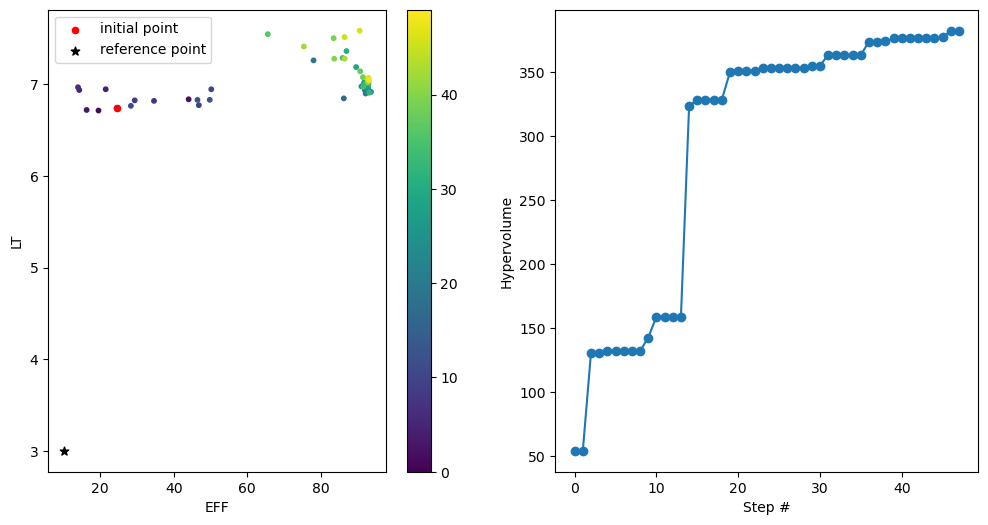

In [18]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i,df=opt.data)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

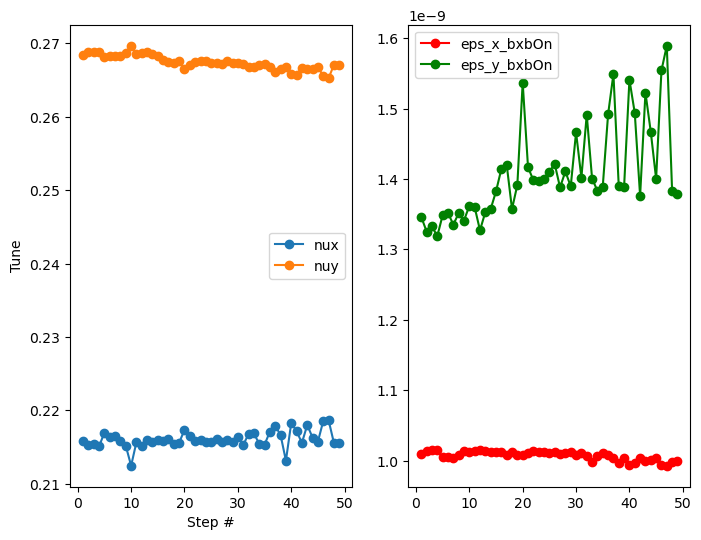

In [19]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [20]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][22:02:19.312 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:02:19.314 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': 0.0, 'SL3': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][22:02:19.319 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 7.135584290000001, 'SL3': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.171021682, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.164180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + +0.000 -> +7.136
SL3    : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.108; RMS(dx, dy) [m] = (2.686e-06, 1.731e-06)
Max FCOR I [A] = 0.104; RMS(dx, dy) [m] = (1.083e-05, 1.319e-06)
Max FCOR I [A] = 0.104; RMS(dx, dy) [m] = (1.083e-05, 1.319e-06)
Max FCOR I [A] = 0.043; RMS(dx, dy) [m] = (3.962e-06, 1.282e-06)
Orbit correction converged


[INFO ][22:02:27.456 opt_funcs.  734] Lifetime measurement START
[INFO ][22:02:36.475 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.532 (raw tau [hr] = 8.786, epsy [pm] = 14.92) (took 9.0 [s])
Inj. Eff. = 79.57 (took 18.5 [s])
Eval. func. finished.


[DEBUG][22:02:55.027 evaluators  211] Result: output={'result': {'_nux': 0.21652088218361518, '_nuy': 0.2657149130617569, '_eps_x_bxbOn': 9.967440508972855e-10, '_eps_y_bxbOn': 1.4918333672956312e-11, '_eps_x_bxbOff': 9.89932203368392e-10, '_eps_y_bxbOff': 1.4916260091052224e-11, 'LT': 7.53165186256209, '_raw_LT': 8.785539222106902, 'EFF': 79.57272463053545}, 'exception': None, 'traceback': '', 'wall_time': 35.71162818092853, 'cpu_time': 15.63015604899988}
[DEBUG][22:02:55.030 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:02:55.105 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00043.json] in [0.05890]s


MOGA add_data (+50): len(self._offspring)=50/8
MOGA add_data: creating next generation


In [21]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][22:03:12.602 optimizer.  573] Evaluating 1 inputs
[DEBUG][22:03:12.605 evaluators  193] Data kwargs: row={'SH1N': -0.08, 'SH3N': -0.04, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': -0.15, 'SL3': -0.15, 'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.02, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.02, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][22:03:12.609 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8865824200000003, 'SH3N': -1.211021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 6.98558429, 'SL3': -6.042172122000001, 'SH1-DW08': 3.9865824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.1510216819999999, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.144180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.133; RMS(dx, dy) [m] = (1.886e-05, 1.115e-06)
Max FCOR I [A] = 0.133; RMS(dx, dy) [m] = (1.886e-05, 1.115e-06)
Max FCOR I [A] = 0.071; RMS(dx, dy) [m] = (6.248e-06, 1.144e-06)
Orbit correction converged


[INFO ][22:03:19.754 opt_funcs.  734] Lifetime measurement START
[INFO ][22:03:24.756 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.721 (raw tau [hr] = 7.296, epsy [pm] = 12.89) (took 5.0 [s])
Inj. Eff. = 39.45 (took 19.2 [s])
Eval. func. finished.


[DEBUG][22:03:43.931 evaluators  211] Result: output={'result': {'_nux': 0.21508655569164997, '_nuy': 0.2673628557872058, '_eps_x_bxbOn': 1.0029215871918138e-09, '_eps_y_bxbOn': 1.3080396089272518e-11, '_eps_x_bxbOff': 1.0119559840659504e-09, '_eps_y_bxbOff': 1.2893942694934378e-11, 'LT': 6.721424435884248, '_raw_LT': 7.295831318515819, 'EFF': 39.446331730345534}, 'exception': None, 'traceback': '', 'wall_time': 31.324857722967863, 'cpu_time': 11.379536786000017}
[DEBUG][22:03:43.935 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][22:03:44.004 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-21_30_54-aps_mggpo-de9872d39e-bfdca030/dump_auto_00044.json] in [0.05731]s


MOGA add_data (+51): len(self._offspring)=51/8
MOGA add_data: creating next generation


In [22]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')

In [23]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.080000,-0.040000,0.000000,0.000000,-0.150000,-0.150000,0.020000,0.000000,0.000000,0.020000,...,True,0.215880,0.268461,1.009581e-09,1.346125e-11,1.015755e-09,1.332449e-11,6.741538,7.103550,24.491359
2,-0.099465,-0.044929,-0.002763,-0.000443,-0.167116,-0.127883,0.005259,0.008194,-0.004424,0.025328,...,True,0.215331,0.268858,1.013122e-09,1.325413e-11,1.014801e-09,1.315979e-11,6.714954,7.040210,19.527981
3,-0.058034,-0.035142,0.011872,0.012815,-0.130499,-0.182801,0.028458,-0.015234,0.019547,0.013865,...,True,0.215453,0.268797,1.014375e-09,1.332781e-11,1.015409e-09,1.337421e-11,6.837850,7.233200,44.066581
4,-0.086915,-0.038442,0.006574,-0.009609,-0.179889,-0.155408,0.038356,0.023377,-0.019510,0.017814,...,True,0.215117,0.268797,1.014329e-09,1.318761e-11,1.014352e-09,1.310908e-11,6.721174,7.045517,16.285926
5,-0.068893,-0.041602,-0.016459,0.005018,-0.123165,-0.135287,0.019897,-0.000051,0.004094,0.022257,...,True,0.216979,0.268126,1.004574e-09,1.348549e-11,1.004080e-09,1.346867e-11,6.947714,7.389293,21.483817
6,-0.077729,-0.037424,-0.010899,-0.015085,-0.148576,-0.149775,0.010437,0.016947,0.014087,0.021404,...,True,0.216307,0.268309,1.004448e-09,1.351927e-11,1.003133e-09,1.343247e-11,6.939272,7.376186,14.285995
7,-0.083482,-0.042615,0.001753,0.003524,-0.154400,-0.160497,0.035126,-0.007223,-0.009888,0.018718,...,True,0.216551,0.268217,1.003213e-09,1.335373e-11,1.001352e-09,1.332067e-11,6.969546,7.381120,13.944779
8,-0.067791,-0.045888,0.017730,-0.006916,-0.113136,-0.168600,0.025694,0.001962,0.009832,0.014770,...,True,0.215819,0.268339,1.007284e-09,1.351049e-11,1.010221e-09,1.348544e-11,6.820371,7.273812,34.641991
9,-0.049144,-0.035142,-0.016590,0.012815,-0.130499,-0.182801,0.028418,-0.000148,0.019547,0.013919,...,True,0.215178,0.268675,1.014127e-09,1.340910e-11,1.011402e-09,1.326873e-11,6.826171,7.236221,29.384431
10,-0.058034,-0.035142,0.000679,0.012815,-0.072466,-0.182801,0.028458,-0.015234,0.019547,0.013865,...,True,0.212462,0.269682,1.012036e-09,1.361796e-11,1.015343e-09,1.346372e-11,6.773430,7.247355,46.846329
